In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import Audio, display

In [2]:
SR = 44100

In [3]:
def log10(x):
    return np.log10(x.clip(min=1e-30))

def show(y):
    x = range(len(y))
    print(np.max(y), np.min(y))
    plt.plot(x, y)
    plt.show()

def show_fft(y):
    fft_y = 20 * log10(np.abs(fft(y)) / SR)
    plt.plot(range(len(y)), fft_y)
    plt.xlim(0, 15000)
    plt.ylim(-120, 0)
    plt.show()

def save_audio(y, filename='test.wav'):
    audio = Audio(y, rate=SR)
    display(audio)
    open(filename, "wb").write(audio.data)

def save_audio_stereo(y, filename='test.wav'):
    left, right = np.array([v[0] for v in y]), np.array([v[1] for v in y])
    save_audio([left, right], filename)

In [4]:
INV_SR = 1 / SR
TWO_PI = 2 * math.pi
TWO_PI_BY_SR = TWO_PI / SR

def sec(x):
    return int(x * SR)

def mix(x, y, a):
     return x * (1 - a) + y * a

def hz(t, freq):
    return TWO_PI_BY_SR * freq * t

In [5]:
NOTES = {
    'c-': 0,
    'c#': 1,
    'd-': 2,
    'd#': 3,
    'e-': 4,
    'f-': 5,
    'f#': 6,
    'g-': 7,
    'g#': 8,
    'a-': 9,
    'a#': 10,
    'b-': 11
}

def get_midi_note(m):
    return 440 * 2 ** ((m - 69) / 12)

def get_note(name):
    n, o = name[:2].lower(), int(name[2])
    return get_midi_note(NOTES[n] + 12 * (o + 2))

def parse_data(text):
    cols = text.split()
    data = [None if cols[0].startswith('.') else get_note(cols[0])]
    for col in cols[1:]:
        data.append(None if col.startswith('.') else int(col, 16))
    return data

def parse_row(text):
    return [parse_data(data) for data in text.split('|')]

def parse_song(text):
    return [parse_row(row) for row in text.strip().split('\n')]

song = '''
C-3 0F|D-4 FF|... FF|... FF
... ..|... ..|... ..|... ..
E-3 ..|E-4 50|A-2 50|... 50
... ..|... ..|... ..|... ..
G-3 ..|... 50|... 50|... 50
... ..|... ..|... ..|... ..
'''

parse_song(song)

[[[261.6255653005986, 15], [587.3295358348151, 255], [None, 255], [None, 255]],
 [[None, None], [None, None], [None, None], [None, None]],
 [[329.6275569128699, None], [659.2551138257398, 80], [220.0, 80], [None, 80]],
 [[None, None], [None, None], [None, None], [None, None]],
 [[391.99543598174927, None], [None, 80], [None, 80], [None, 80]],
 [[None, None], [None, None], [None, None], [None, None]]]

In [6]:
def dsf(freq, mod_factor, width):
    mfreq = mod_factor * freq
    num = math.sin(freq) - width * math.sin(freq - mfreq)
    return num / (1 + width * (width - 2 * math.cos(mfreq)))

def dsf2(freq, mod_factor, width):
    mfreq = mod_factor * freq
    num = math.sin(freq) * (1 - width * width)
    return num / (1 + width * (width - 2 * math.cos(mfreq)))

def saw(freq, width=0.5):
    return dsf(freq, 1, width)

def square(freq, width=0.5):
    return dsf(freq, 2, width)

def envelope(t, deltas, levels, level_0=0, func=mix):
    t_0 = 0
    for dt, level in zip(deltas, levels):
        if t <= t_0 + dt:
            return func(level_0, level, (t - t_0) / dt)
        t_0, level_0 = t_0 + dt, level
    return level_0

def step(x, y, a):
    return y

def delay(buf, pos, x, level, fb=0.5):
    old = buf[pos]
    y = x + old * level
    buf[pos] = old * fb + x
    pos = (pos + 1) % len(buf)
    return y, pos

def set_stereo(x, pan):
    pan = (pan + 1) / 2
    return x * math.sqrt(1 - pan), x * math.sqrt(pan)

1.332938962911025 -1.333322988945419


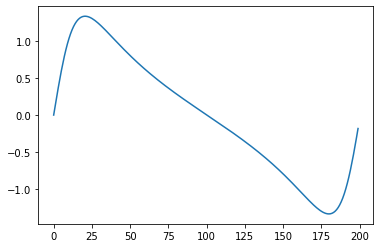

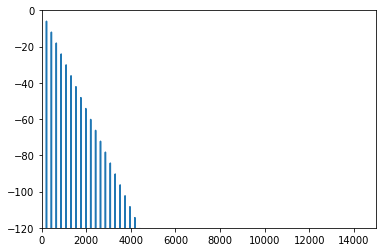

In [7]:
def play(freq):
    for t in range(sec(1)):
        yield dsf(hz(t, freq), 1, 0.5)

freq = 220
y = list(play(freq))
show(y[:SR // freq])
show_fft(y)
save_audio(y, 'saw.wav')

In [8]:
def play():
    for t in range(sec(3)):
        yield 0.1 * math.sin(hz(t, 2)) * dsf(hz(t, 450), 0.120, 0.1 + 0.7 * abs(math.sin(hz(t, 0.2))))

y = list(play())
save_audio(y, 'filter.wav')

1.6058195215302873 -1.6986298354947107


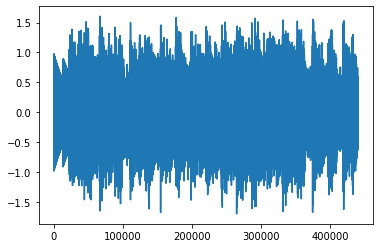

In [9]:
def play():
    buf = [0] * sec(0.3)
    pos = 0
    for _ in range(20):
        freq = random.randint(100, 500)
        for t in range(sec(0.5)):
            e1 = envelope(t * INV_SR, [0.001, 1], [1, 0])
            x = 0.5 * dsf(hz(t, freq), 3.4, 0.5 * e1) * e1
            y, pos = delay(buf, pos, x, 0.6, 0.8)
            yield y

y = list(play())
show(y)
save_audio(y, 'bells.wav')

In [10]:
class Phasor:
    def __init__(self):
        self.phase = 0

    def reset(self):
        self.phase = 0
    
    def next(self, freq):
        p = self.phase
        self.phase = (self.phase + TWO_PI_BY_SR * freq) % TWO_PI
        return p

class Env:
    def __init__(self, deltas, levels):
        self.deltas = deltas
        self.levels = levels
        self.t = 0
        self.size = sum(deltas)
        self.val = 0

    def reset(self):
        self.t = 0
    
    def next(self):
        if self.t < self.size:
            self.val = envelope(self.t, self.deltas, self.levels, self.val)
            self.t += INV_SR
        return self.val

class Delay:
    def __init__(self, size, level, fb=0.5):
        self.buf = [0] * sec(size)
        self.level = level
        self.fb = fb
        self.pos = 0

    def next(self, x):
        y, self.pos = delay(self.buf, self.pos, x, self.level, self.fb)
        return y

def update(self, freq, vol):
    if freq is not None:
        self.freq = freq
        self.env.reset()
    if vol is not None:
        self.vol = vol / 255

class SquareVoice:
    def __init__(self):
        self.ph1 = Phasor()
        self.ph2 = Phasor()        
        self.freq = 0
        self.vol = 0
        self.env = Env([0.01, 0.3], [1, 0])

    update = update

    def next(self):
        a = square(self.ph1.next(self.freq) + 2 * math.sin(self.ph2.next(4)))
        return self.vol * a * self.env.next()

class SawVoice:
    def __init__(self):
        self.ph1 = Phasor()
        self.ph2 = Phasor()        
        self.ph3 = Phasor()        
        self.dly = Delay(0.5, 0.5)
        self.freq = 0
        self.vol = 0
        self.env = Env([0.01, 0.1], [1, 0.5])

    update = update

    def next(self):
        mod = 0.2 + abs(1 + math.sin(self.ph2.next(1))) * 0.3
        a = saw(self.ph1.next(self.freq) + 2 * math.sin(self.ph3.next(4)), width=mod)
        return self.dly.next(self.vol * a * self.env.next())

In [11]:
def play_song(voices, pans, tracks, tick=1/8):
    tick = sec(tick)
    for row in tracks:
        for voice, data in zip(voices, row):
            voice.update(*data)
        for offset in range(tick):
            left, right = 0, 0
            for voice, pan in zip(voices, pans):
                l, r = set_stereo(voice.next(), pan)
                left += l
                right += r
            yield left, right

1.9928185277454076 -2.004187346994499


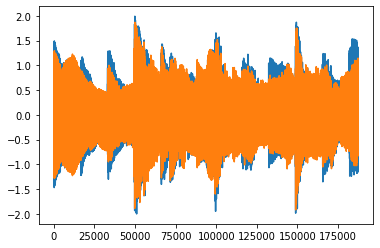

In [12]:
voices = [
    SquareVoice(),
    SawVoice(),
    SquareVoice()
]

pans = [-1, 0, 1]

song = '''
C-3 80 | E-4 FF | C-5 50
... .. | ... .. | D-5 45
... .. | ... .. | C-5 40
E-3 .. | ... .. | D-5 35
... .. | ... .. | C-5 30
... .. | ... .. | D-5 25
G-3 .. | D-4 A0 | C-5 20
... .. | ... .. | D-5 15
... .. | ... .. | C-5 10
C-3 .. | C-4 FF | D-5 50
... .. | ... .. | C-5 45
... .. | ... .. | D-5 40
E-3 .. | G-3 FF | C-5 35
... .. | ... .. | D-5 30
... .. | ... .. | C-5 25
G-3 .. | ... .. | D-5 20
... .. | ... .. | C-5 15
... .. | ... .. | D-5 10
C-3 .. | A-3 A0 | C-5 50
... .. | ... .. | D-5 45
... .. | ... .. | C-5 40
E-3 .. | ... .. | D-5 35
... .. | ... .. | C-5 30
... .. | ... .. | D-5 25
G-3 .. | ... .. | C-5 20
... .. | ... .. | D-5 15
... .. | ... .. | C-5 10
C-3 .. | C-4 FF | D-5 50
... .. | ... .. | C-5 45
... .. | ... .. | D-5 40
E-3 .. | ... .. | C-5 35
... .. | ... .. | C-5 30
... .. | ... .. | D-5 25
G-3 .. | ... .. | C-5 20
'''

y = list(play_song(voices, pans, parse_song(song)))
show(y)
save_audio_stereo(y, 'song.wav')